In [27]:
import numpy as np
#读取视频文件
def loadmkv(file,img_num=10):
    import cv2
    #标注处理
    labels_list = []
    i = 1
    with open(file + '_steering.csv', encoding='utf-8') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        for row in csv_reader:
            labels_list.append([float(row['wheel'])])
            if (i>=img_num):
                break
            i = i + 1
    #图像处理        
    cap = cv2.VideoCapture(file +'_front.mkv')
    ret = True
    frame_list = []
    i = 1 
    while(ret == True):
        ret, frame = cap.read()
        if (ret == True):
            frame = cv2.resize(frame,(480,270))
            frame_list.append(frame)
            del frame
            if (i>=img_num):
                break
            i = i + 1
            #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            #cv2.imshow('frame',gray)
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
    return (np.array(frame_list),np.array(labels_list))

In [29]:
import pickle
from os.path import isfile, isdir
import csv

epochs_path = '../epochs/'
outputf_path = '../output/'
for i in range(1,2):
    filename = epochs_path + 'epoch0' + str(i)
    outputfilename = outputf_path + 'epoch0' + str(i)
    if not isfile(outputfilename + '.p'):
        features,labels = loadmkv(filename,100)
        with open(outputfilename + '.p', 'wb') as outputfile:
            pickle.dump((features,labels), outputfile)
        del features,labels
        
print('load file completion')

load file completion


In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        x,y = pickle.load(fo, encoding='bytes')
    return x,y

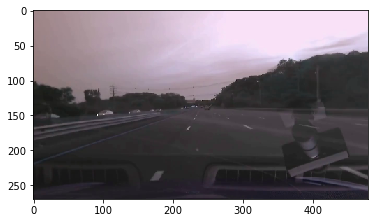

x shape: (100, 270, 480, 3)
y shape: (100, 1)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 270, 480, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 135, 240, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 135, 240, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_295 (Activation)     (None, 135, 240, 64) 0           bn_conv1[0][0]                   
_____________________

ValueError: Error when checking target: expected avg_pool to have 4 dimensions, but got array with shape (100, 10)

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Input
from keras.preprocessing import image
from keras.applications import ResNet50
from keras.datasets import cifar10
import keras

x,y = unpickle('../output/epoch01.p')
from matplotlib import pyplot as plot
%matplotlib inline

plot.imshow(x[0])
plot.show()

print('x shape:', x.shape)
print('y shape:', y.shape)
num_classes =10
y = keras.utils.to_categorical(y, num_classes)
print(y[0])
input_tensor = Input(shape=(270, 480, 3))
model = ResNet50(include_top=False, weights=None,input_tensor=input_tensor)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()
model.fit(x, y,
          epochs=10,
          batch_size=10,
          validation_data=(x, y),
          shuffle=True)
#score = model.evaluate(x_test, y_test, batch_size=10)
print('Score:', score)